In [63]:
'''
Beginning implementation of "Motion without movement" illusions
'''

import cv2
from PIL import Image
import matplotlib.pylab as plt
import os
import numpy as np 
import imageio
from skimage.exposure import rescale_intensity
from math import exp, cos, sin


(-0.5, 299.5, 326.5, -0.5)

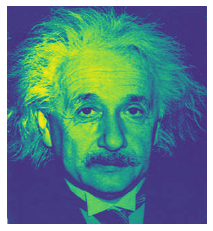

In [42]:
# load in image to be transformed  

img_pth = "./einstein.jpeg"

img = cv2.imread(img_pth)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # ensure unicolor scale for now 

plt.imshow(img)
plt.axis('off')

In [50]:

def convolve2D(image, kernel, padding=0, strides=1):
    
    # code from: https://medium.com/analytics-vidhya/2d-convolution-using-python-numpy-43442ff5f381
    
    # Cross Correlation
    kernel = np.flipud(np.fliplr(kernel))

    # Gather Shapes of Kernel + Image + Padding
    xKernShape = kernel.shape[0]
    yKernShape = kernel.shape[1]
    xImgShape = image.shape[0]
    yImgShape = image.shape[1]

    # Shape of Output Convolution
    xOutput = int(((xImgShape - xKernShape + 2 * padding) / strides) + 1)
    yOutput = int(((yImgShape - yKernShape + 2 * padding) / strides) + 1)
    output = np.zeros((xOutput, yOutput))

    # Apply Equal Padding to All Sides
    if padding != 0:
        imagePadded = np.zeros((image.shape[0] + padding*2, image.shape[1] + padding*2))
        imagePadded[int(padding):int(-1 * padding), int(padding):int(-1 * padding)] = image
        print(imagePadded)
    else:
        imagePadded = image

    # Iterate through image
    for y in range(image.shape[1]):
        # Exit Convolution
        if y > image.shape[1] - yKernShape:
            break
        # Only Convolve if y has gone down by the specified Strides
        if y % strides == 0:
            for x in range(image.shape[0]):
                # Go to next row once kernel is out of bounds
                if x > image.shape[0] - xKernShape:
                    break
                try:
                    # Only Convolve if x has moved by the specified Strides
                    if x % strides == 0:
                        output[x, y] = (kernel * imagePadded[x: x + xKernShape, y: y + yKernShape]).sum()
                except:
                    break
    # normalize output scale: https://www.pyimagesearch.com/2016/07/25/convolutions-with-opencv-and-python/ 
    output = rescale_intensity(output, in_range=(0, 255))
    output = (output * 255).astype("uint8")
    return output

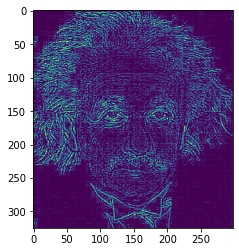

In [51]:
kernel = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])

sharpen = np.array((
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]), dtype="int")

conv_img = convolve2D(img, kernel)

plt.imshow(conv_img)

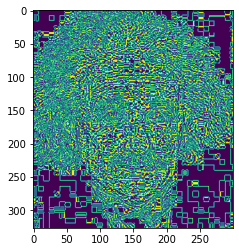

In [56]:
from scipy.ndimage import gaussian_filter, laplace

image_first_derivative = gaussian_filter(img, sigma=3)
image_sec_derivative = laplace(img)

plt.imshow(image_sec_derivative)

In [65]:
def second_deriv_gauss(x,y,theta=0): 
    # G_2^theta = k_a(theta)*G_2a + k_b(theta)*G_2b + k_c(theta)*G_2c
    # values from Table 1 (p. 29)
    
    G_2a = 0.9123 * (2*x^2 - 1)*exp(-(x^2 + y^2))
    G_2b = 1.843 * x * y * exp(-(x^2 + y^2))
    G_2c = 0.9123*(2*y^2 - 1)*exp(-(x^2+y^2))
    
    k_a = cos(theta) ** 2 
    k_b = -2*cos(theta) * sin(theta)
    k_c = sin(theta)**2
    
    return k_a * G_2a + k_b * G_2b + k_c * G_2c

In [75]:
sample_filter = []
filter_size = 5 
for x in range(filter_size):#img.shape[0])
    filt_vals = []
    for y in range(filter_size):#img.shape[1]):
        filt_val = 0.9213*(2*(x**2 -1)*exp(-(x**2 + y**2)))
        filt_vals.append(filt_val)#second_deriv_gauss(x,y,0))
    sample_filter.append(filt_vals)
sample_filter    

[[-1.8426,
  -0.6778546583024997,
  -0.0337483962163816,
  -0.00022739490501011577,
  -2.0735731293770686e-07],
 [0.0, 0.0, 0.0, 0.0, 0.0],
 [0.1012451886491448,
  0.03724602342154464,
  0.0018543703145195052,
  1.2494648895909872e-05,
  1.139364499411586e-08],
 [0.0018191592400809262,
  0.0006692312846428367,
  3.3319063722426326e-05,
  2.2450208542085994e-07,
  2.0471940292466165e-10],
 [3.1103596940656027e-06,
  1.1442373860950323e-06,
  5.696822497057931e-08,
  3.838488804837406e-10,
  3.500248716114139e-13]]

In [74]:
exp

<function math.exp>

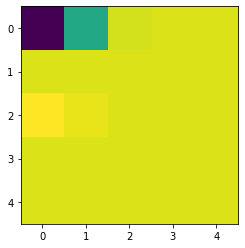

In [76]:
plt.imshow(sample_filter)

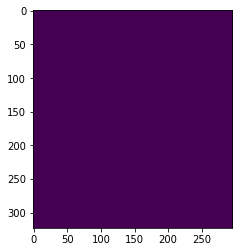

In [77]:
conv_img = convolve2D(img, sample_filter)

plt.imshow(conv_img)

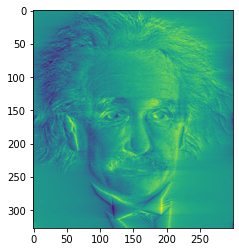

In [86]:
from scipy.signal import hilbert

transf_img =  np.imag(hilbert(img)) # help from: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.hilbert.html

plt.imshow(transf_img)

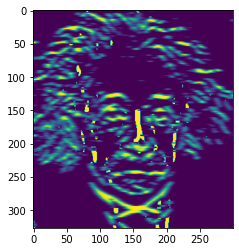

In [90]:
from scipy.ndimage import gaussian_laplace

transf_img =  gaussian_laplace(img, sigma=3) # help from: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.hilbert.html

plt.imshow(transf_img)

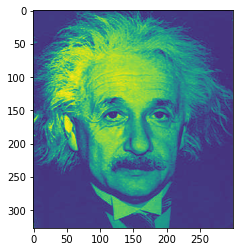

In [82]:
plt.imshow(img)